In [10]:
import pandas as pd
import numpy as np
import numpy.random as random
import itertools
import matplotlib as plt

In [108]:
PERSONS = (PA,PB,PC) = ['A','B','C']
PERSONALITIES = (TRUEIST,LIAR,RANDOMIST) = ( 'L', 'T' , 'R')
YES_NO = (YES,NO) = ('YES','NO')
BOOL_TOKENS = (BOOL_X,BOOL_Y) = ['X','Y']

df = pd.DataFrame(
    [(*bt,*lwr) 
        for bt in itertools.permutations( BOOL_TOKENS )
        for lwr in itertools.permutations( PERSONALITIES ) 
    ],columns=[*YES_NO,*PERSONS])
df['P(H)'] = 1/ len(df)
df

,YES,NO,A,B,C,P(H)
0,X,Y,L,T,R,0.083333
1,X,Y,L,R,T,0.083333
2,X,Y,T,L,R,0.083333
3,X,Y,T,R,L,0.083333
4,X,Y,R,L,T,0.083333
5,X,Y,R,T,L,0.083333
6,Y,X,L,T,R,0.083333
7,Y,X,L,R,T,0.083333
8,Y,X,T,L,R,0.083333
9,Y,X,T,R,L,0.083333


In [3]:
def init_hidden():
    choice = random.choice(df.index.size)
    return df.iloc[choice,:]
    
hidden = init_hidden()

def ask(person,question,h=hidden,show_random=False,show_prob=False):
    assert person in PERSONS
    true_answer = bool(question(h))
    
    eff = None
    if h[person] == LIAR:
        eff = h[YES] if not(true_answer) else h[NO]
    elif h[person] == TRUEIST:
        eff = h[YES] if true_answer else h[NO]
    else: 
        assert h[person] == RANDOMIST
        eff = '?' if (show_random or show_prob) else BOOL_TOKENS[random.choice(2)]
    
    assert eff in BOOL_TOKENS or eff == '?'
    BOOL_X_PROB_BY_EFF = { '?':0.5, BOOL_X:1.0, BOOL_Y:0.0 }
    if show_prob:
        prob_x = BOOL_X_PROB_BY_EFF[eff]
        return { BOOL_X : prob_x, BOOL_Y : 1 - prob_x }
    else:
        return eff



In [118]:
def question_other_role(interviewed,subject,role):
   return  lambda h : (h[subject] == role)  ==  ( (h[interviewed] == LIAR) == (h[YES] =='X') )

Q1 = question_other_role(PA,PB,RANDOMIST)
Q2_Q1X = question_other_role(PB,PC,RANDOMIST)
Q3_Q2Y_Q1X = question_other_role(PB,PC,TRUEIST)
Q3_Q2Y_Q1X = question_other_role(PB,PA,TRUEIST)

(PA,PB,RANDOMIST,{ 
    BOOL_X: (PB,PC,RANDOMIST,{
        BOOL_X: ( PB,PC,TRUEIST, {
            BOOL_X : {PA:RANDOMIST,PB:LIAR,PC:TRUEIST}
        }
        
        )
    })})
    
ans_Q1 = ask('A', Q1)
print ( "Q1 A: ",ans_Q1)

if ans_Q1 == BOOL_X:
    # B is not RANDOMIST
    ans_Q2 = ask('B', Q2_Q1X)
    print ( "Q2 B: ",ans_Q2)
    if ans_Q2 == BOOL_X:
        # A is randomist
        ans_Q3 = ask('B', Q3_Q2X_Q1X)
        print ( "Q3 B: ",ans_Q3)
    else:
        # C is randomist
        ans_Q3 = ask('B', Q3_Q2Y_Q1X)
        print ( "Q3 B: ",ans_Q3)
else:
    # C is RANDOMIST
    ans_Q2 = ask('B', Q2_Q1Y)
    print ( "Q2 B: ",ans_Q2)

Q1 A:  X
Q2 B:  Y
Q3 B:  Y


In [119]:

#df['A_YES_IS_X'] = [ ask('A',lambda h: h[YES] =='X',h=v,show_random=True) for i,v in df.iterrows()] 
#df['A_TRUE'] = [ ask('A',lambda h: True,h=v,show_random=True) for i,v in df.iterrows()] 
likelyhood_Q1_X = [ ask('A',Q1,h=v,show_prob=True)[BOOL_X] for i,v in df.iterrows()] 
marginal_likelyhood_Q1_X = (df['P(H)'] * likelyhood_Q1_X).sum()
df['P(H|Q1=X)'] = ( likelyhood_Q1_X * df['P(H)'] ) / marginal_likelyhood_Q1_X

likelyhood_Q2_X = [ ask('B',Q2_Q1X,h=v,show_prob=True)[BOOL_X] for i,v in df.iterrows()] 
marginal_likelyhood_Q2_X_Q1_X = (df['P(H|Q1=X)'] * likelyhood_Q2_X).sum()
df['P(H|Q1=X,Q2=X)'] = ( likelyhood_Q2_X * df['P(H|Q1=X)'] ) / marginal_likelyhood_Q2_X_Q1_X 


likelyhood_Q3X_Q2X_Q1X = [ ask('B',Q3_Q2X_Q1X,h=v,show_prob=True)[BOOL_X] for i,v in df.iterrows()] 
marginal_likelyhood_Q3X_Q2X_Q1X = (df['P(H|Q1=X,Q2=X)'] * likelyhood_Q3X_Q2X_Q1X).sum()
df['P(H|Q1=X,Q2=X,Q3=X)'] = ( likelyhood_Q3X_Q2X_Q1X * df['P(H|Q1=X,Q2=X)'] ) / marginal_likelyhood_Q3X_Q2X_Q1X 

likelyhood_Q2_Y = [ ask('B',Q2_Q1X,h=v,show_prob=True)[BOOL_Y] for i,v in df.iterrows()] 
marginal_likelyhood_Q2_Y_Q1_X = (df['P(H|Q1=X)'] * likelyhood_Q2_Y).sum()
df['P(H|Q1=X,Q2=Y)'] = ( likelyhood_Q2_Y * df['P(H|Q1=X)'] ) / marginal_likelyhood_Q2_Y_Q1_X 

likelyhood_Q1_Y = [ ask('A',Q1,h=v,show_prob=True)[BOOL_Y] for i,v in df.iterrows()] 
marginal_likelyhood_Q1_Y = (df['P(H)'] * likelyhood_Q1_Y).sum()
df['P(H|Q1=Y)'] = ( likelyhood_Q1_Y * df['P(H)'] ) / marginal_likelyhood_Q1_Y


df['Q1=X,Q2'] = [ ask('B',Q2_Q1X,h=v,show_random=True) for i,v in df.iterrows()] 

In [120]:
df

,YES,NO,A,B,C,P(H),P(H|Q1=X),"P(H|Q1=X,Q2=X)","P(H|Q1=X,Q2=X,Q3=X)","P(H|Q1=X,Q2=Y)",P(H|Q1=Y),"Q1=X,Q2"
0,X,Y,L,T,R,0.083333,0.166667,0.00,0.0,0.25,0.000000,Y
1,X,Y,L,R,T,0.083333,0.000000,0.00,0.0,0.00,0.166667,?
2,X,Y,T,L,R,0.083333,0.166667,0.00,0.0,0.25,0.000000,Y
3,X,Y,T,R,L,0.083333,0.000000,0.00,0.0,0.00,0.166667,?
4,X,Y,R,L,T,0.083333,0.083333,0.25,0.5,0.00,0.083333,X
5,X,Y,R,T,L,0.083333,0.083333,0.25,0.0,0.00,0.083333,X
6,Y,X,L,T,R,0.083333,0.166667,0.00,0.0,0.25,0.000000,Y
7,Y,X,L,R,T,0.083333,0.000000,0.00,0.0,0.00,0.166667,?
8,Y,X,T,L,R,0.083333,0.166667,0.00,0.0,0.25,0.000000,Y
9,Y,X,T,R,L,0.083333,0.000000,0.00,0.0,0.00,0.166667,?


In [121]:
df2 = df.set_index([ *YES_NO, *PERSONS ])
pass

In [102]:
df2.iloc[:,0:4]

P(H)  P(H|Q1=X)  P(H|Q1=X,Q2=X)  P(H|Q1=X,Q2=Y)
YES NO A B C                                                     
X   Y  L T R  0.083333   0.166667            0.00            0.25
         R T  0.083333   0.000000            0.00            0.00
       T L R  0.083333   0.166667            0.00            0.25
         R L  0.083333   0.000000            0.00            0.00
       R L T  0.083333   0.083333            0.25            0.00
         T L  0.083333   0.083333            0.25            0.00
Y   X  L T R  0.083333   0.166667            0.00            0.25
         R T  0.083333   0.000000            0.00            0.00
       T L R  0.083333   0.166667            0.00            0.25
         R L  0.083333   0.000000            0.00            0.00
       R L T  0.083333   0.083333            0.25            0.00
         T L  0.083333   0.083333            0.25            0.00

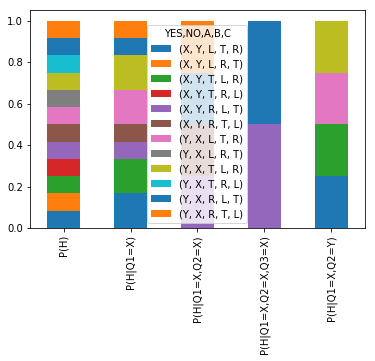

In [122]:
df2.iloc[:,0:5].T.plot(kind='bar', stacked=True)